# Idea

Statistical arbitrage through pairs trading with cointegrated pairs:
  - Time horizon of data: 4h, 8h, 12h, 24h, 48h
  - Method of identification of cointegrated pairs
      - Fixed set of cointegrated pairs calculated from a training period
      - Dynamically determined cointegrated pairs calculated each period or every several periods
  - Method of hedge-ratio calculation:
      - Pairs with a fixed hedge ratio calculated from a training period
      - Pairs with a dynamic hedge ratio calculated from a look-back period
  - Significance level for being considered cointegrated:
      - 0.10
      - 0.05
      - 0.02
  - Entry and exit levels
  - Lookback window length to calculate z-score (presumably shorter than window to calculate dynamic hedge ratio)


Separate idea:
  - Use price for cointegration or use returns for cointegration
  
  
Also consider baskets instead.

# Methodology

To be filled in: detail the steps, including data acquisition, cointegration testing, and the backtesting process.

# Results

To be filled in: summarize the key performance metrics you calculated.

# Future Work

To be filled in: mention potential improvements, such as adding more pairs, optimizing entry/exit rules, or incorporating more advanced statistical models like the Kalman filter.

Relevant sources:
  - https://medium.com/@trading.dude/unlocking-the-hidden-potential-using-statistical-arbitrage-as-an-indicator-in-python-a8595392def4
  - https://github.com/nirajdsouza/statistical-arbitage-strategy

# Imports

In [1]:
# import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from binance.client import Client as bnb_client
from datetime import datetime
from statsmodels.tsa.stattools import coint

from ipynb.fs.full.utility_functions import (
    get_train_test_data,
    get_alpha_beta_to_asset,
    get_gross_returns_and_net_returns,
    get_rank_demeaned_normalized_signal,
    get_strategy_stats,
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Get Historical Data For Cryptocurrencies

In [2]:
# The universe is based on this snapshot from December 20, 2020: https://coinmarketcap.com/historical/20201220/

univ = [
    "BTCUSDT", "ETHUSDT", "ADAUSDT", "BNBUSDT", "XRPUSDT", "DOTUSDT", "MATICUSDT", "LTCUSDT", "BCHUSDT",
    "LINKUSDT", "XLMUSDT", "USDCUSDT", "EOSUSDT", "TRXUSDT", "XTZUSDT", "FILUSDT", "NEOUSDT", "DAIUSDT",
    "DASHUSDT", "VETUSDT", "ATOMUSDT", "AAVEUSDT", "UNIUSDT", "GRTUSDT", "THETAUSDT", "IOTAUSDT", "BUSDUSDT",
    "ZECUSDT", "YFIUSDT", "ETCUSDT", "WAVESUSDT", "COMPUSDT", "SNXUSDT", "DOGEUSDT", "MKRUSDT", "ZILUSDT",
    "SUSHIUSDT", "KSMUSDT", "OMGUSDT", "ONTUSDT", "ALGOUSDT", "EGLDUSDT", "BATUSDT", "DGBUSDT", "ZRXUSDT",
    "TUSDUSDT", "QTUMUSDT", "ICXUSDT", "AVAXUSDT", "RENUSDT", "HBARUSDT", "NEARUSDT", "LRCUSDT", "CELOUSDT",
    "KNCUSDT", "LSKUSDT", "OCEANUSDT", "QNTUSDT", "USTUSDT", "BANDUSDT", "MANAUSDT", "ENJUSDT", "ANTUSDT",
    "BNTUSDT", "ZENUSDT", "NMRUSDT", "RVNUSDT", "IOSTUSDT", "OXTUSDT", "CRVUSDT", "MATICUSDT", "HNTUSDT",
    "BALUSDT", "CHZUSDT"
]

should_download_stock_data = False

In [3]:
client = bnb_client(tld='US')

def get_binance_px(symbol, freq, start_ts = '2020-12-20'):
    data = client.get_historical_klines(symbol, freq, start_ts)
    columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume',
               'num_trades', 'taker_base_volume', 'taker_quote_volume', 'ignore']
    data = pd.DataFrame(data, columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 


if should_download_stock_data:
    freq = '4h'
    px = {}
    for x in univ:
        print(f"Downloading data for symbol {x}")
        data = get_binance_px(x, freq)
        px[x] = data.set_index('open_time')['close']

    px = pd.DataFrame(px).astype(float)
    px.to_csv('./class_project_input_prices.csv')
else:
    px = pd.read_csv('./class_project_input_prices.csv')
    date_format = "%Y-%m-%d %H:%M:%S"
    px['open_time'] = px['open_time'].apply(lambda t:  datetime.strptime(t, date_format))
    px.set_index('open_time', inplace=True)

# Data up to 2025-08-31 08:00:00
px_popular = px[["BTCUSDT", "ETHUSDT", "LTCUSDT", "XRPUSDT", "ADAUSDT"]]

In [4]:
t = datetime(2024, 1, 1, 0, 0)

popular_train_px, popular_test_px = get_train_test_data(px_popular, t)

# Identifying cointegrated pairs

In [5]:
def find_cointegrated_pairs(data, significance_level=0.05):
    """
    Finds cointegrated pairs using the Engle-Granger two-step method.
    Returns a list of cointegrated pairs with their p-value.
    """
    n = data.shape[1]
    keys = data.columns
    pvalue_matrix = pd.DataFrame(np.ones((n, n)), index=keys, columns=keys)
    pairs = []

    for i in range(n):
        for j in range(i + 1, n):
            series1 = data[keys[i]]
            series2 = data[keys[j]]
            
            joint_non_na_series1 = series1.loc[series1.notna() & series2.notna()]
            joint_non_na_series2 = series2.loc[series1.notna() & series2.notna()]
            
            if len(joint_non_na_series1) == 0 or len(joint_non_na_series2) == 0:
                pvalue_matrix.loc[keys[i], keys[j]] = 1.0
                continue

            # Perform the cointegration test
            score, pvalue, _ = coint(joint_non_na_series1, joint_non_na_series2)
            pvalue_matrix.loc[keys[i], keys[j]] = pvalue

            if pvalue < significance_level:
                pairs.append((keys[i], keys[j], pvalue))
    return pvalue_matrix, pairs

In [ ]:
# Find the cointegrated pairs
pvalue_matrix, cointegrated_pairs = find_cointegrated_pairs(popular_train_px)

In [ ]:
print("Cointegration Test P-value Matrix:")
plt.figure(figsize=(10, 8))
sns.heatmap(pvalue_matrix, xticklabels=pvalue_matrix.columns, yticklabels=pvalue_matrix.columns, cmap='YlGnBu', annot=True)
plt.title('Cointegration P-value Matrix')
plt.show()

print("\nFound Cointegrated Pairs:")
for pair in cointegrated_pairs:
    print(f"Pair: {pair[0]} and {pair[1]}, P-value: {pair[2]:.4f}")

# Implementation

In [17]:
# px is expected to have data for every 4 hours
def get_horizon_to_px(px_df):
    start_time = px_df.index[0]
    end_time = px_df.index[-1]
    return {
        4: px_df,
        8: px_df[px_df.index.hour % 8 == 0],
        12: px_df[px_df.index.hour % 12 == 0],
        24: px_df[px_df.index.hour == 0],
        48: px_df[px_df.index.hour == 0].loc[pd.date_range(start=start_time, end=end_time, freq='2D')],
    }


def get_cointegrated_pairs_with_window(
    training_px,
    num_look_back_periods,
    num_periods_between_recalculation,
    significance_level
):
    time_to_cointegrated_pairs = dict()
    df_index = training_px.index
    for index in range(0, len(training_px), num_periods_between_recalculation):
        look_back_index = max(0, index - num_look_back_periods)
        if look_back_index == 0:
            continue
        input_px = training_px.iloc[look_back_index:index]
        
        time_to_cointegrated_pairs[df_index[index]] = find_cointegrated_pairs(input_px, significance_level)[1]
    return time_to_cointegrated_pairs


# forward fill the indices from time_series_index with the values in time_map based on
# the most recent key from time_map.
def fill_time_map(time_map, time_series_index):
    sorted_keys = sorted(list(time_map.keys()))
    all_times_to_coint_pairs = dict()

    sorted_keys_index = None

    for index in range(len(time_series_index)):
        current_time = time_series_index[index]

        if sorted_keys_index is None and current_time >= sorted_keys[0]:
            sorted_keys_index = 0
        while sorted_keys_index is not None and ((sorted_keys_index + 1) < len(sorted_keys)) and current_time >= sorted_keys[sorted_keys_index + 1]:
            sorted_keys_index += 1

        if sorted_keys_index is not None:
            all_times_to_coint_pairs[current_time] = time_map[sorted_keys[sorted_keys_index]]
        else:
            all_times_to_coint_pairs[current_time] = []
    
    return all_times_to_coint_pairs


def calculate_alpha_beta_at_index(px_df, index, num_look_back_periods, dependent_coin, independent_coin):
    start_index = max(0, index - num_look_back_periods)
    dependent_data = px_df[dependent_coin].iloc[start_index:index]
    independent_data = px_df[independent_coin].iloc[start_index:index]
    
    alpha, beta = get_alpha_beta_to_asset(dependent_data, independent_data)
    return alpha, beta


def get_times_to_cointegrated_pairs_to_hedges(
    horizon_px_df,
    all_times_to_cointegrated_pairs,
    num_look_back_periods,
    num_periods_between_recalculation,
    significance_level):
    
    times_to_cointegrated_pairs_to_hedges = dict()
    horizon_px_df_index = horizon_px_df.index
    for index in range(0, len(horizon_px_df), num_periods_between_recalculation):
        current_time = horizon_px_df_index[index]
        times_to_cointegrated_pairs_to_hedges[current_time] = dict()
        
        for independent_coin, dependent_coin, _ in all_times_to_cointegrated_pairs[current_time]:
            times_to_cointegrated_pairs_to_hedges[current_time][
                (independent_coin, dependent_coin)] = calculate_alpha_beta_at_index(
                    horizon_px_df, index, num_look_back_periods, dependent_coin, independent_coin)
    
    return times_to_cointegrated_pairs_to_hedges


def get_raw_signal(all_times_to_coint_pairs, px_df):
    signal_map = dict()

    for index, value in all_times_to_coint_pairs.items():
        signal_row = pd.Series(0.0, index = px_df.columns)

        for (independent_coin, dependent_coin), (alpha, beta) in value.items():
            dependent_coin_estimate = px_df.loc[index, independent_coin] * beta + alpha

            if px_df.loc[index, dependent_coin] >= dependent_coin_estimate:
                # dependent_coin is overvalued relative to independent_coin; short one share of it
                # independent_coin is undervalued relative to dependent_coin; long beta shares of it

                signal_row[independent_coin] += beta
                signal_row[dependent_coin] -= 1.0
            else:
                # dependent_coin is undervalued relative to independent_coin; long one share of it
                # independent_coin is overvalues relative to dependent_coin; short one share of it

                signal_row[independent_coin] -= beta
                signal_row[dependent_coin] += 1.0

        signal_map[index] = signal_row

    return pd.DataFrame(signal_map).T


def get_returns_from_dynamic_cointegration(
    time_horizon_hours,
    horizon_px_df,
    num_look_back_periods,
    num_periods_between_recalculation,
    significance_level
):
    
    time_to_cointegrated_pairs = get_cointegrated_pairs_with_window(
        horizon_px_df,
        num_look_back_periods,
        num_periods_between_recalculation,
        significance_level)
    
    all_times_to_cointegrated_pairs = fill_time_map(
        time_to_cointegrated_pairs, horizon_px_df.index)
    
    time_to_cointegrated_pairs_to_hedges = get_times_to_cointegrated_pairs_to_hedges(
        horizon_px_df,
        all_times_to_cointegrated_pairs,
        num_look_back_periods,
        num_periods_between_recalculation,
        significance_level)
    
    all_times_to_cointegrated_pairs_to_hedges = fill_time_map(
        time_to_cointegrated_pairs_to_hedges, horizon_px_df.index)
    
    raw_signal = get_raw_signal(all_times_to_cointegrated_pairs_to_hedges, horizon_px_df)
    transformed_signal = get_rank_demeaned_normalized_signal(raw_signal)
    return get_gross_returns_and_net_returns(transformed_signal, horizon_px_df)


# original_px_df should have data for every 4 hours
def get_all_gross_returns_and_net_returns(original_px_df, num_periods_between_recalculation):
    # return map from variations to pair of dataframes of gross returns and net returns
    variation_to_returns = dict()
    
    horizon_to_px = get_horizon_to_px(original_px_df)
    for time_horizon_hours in (4, 8, 12, 24, 48):
        for significance_level in (0.10, 0.05, 0.02):
            num_look_back_periods = 2 * num_periods_between_recalculation
            
            gross_returns, net_returns = get_returns_from_dynamic_cointegration(
                time_horizon_hours,
                horizon_to_px[time_horizon_hours],
                num_look_back_periods,
                num_periods_between_recalculation,
                significance_level
            )
    
            variation_to_returns[(time_horizon_hours, significance_level)] = net_returns

    return variation_to_returns

In [7]:
full_train_px, full_test_px = get_train_test_data(px, t)

In [ ]:
# finished

num_periods_between_recalculation = 6 * 7 * 2

variation_to_returns_2w = get_all_gross_returns_and_net_returns(
    full_train_px,
    num_periods_between_recalculation
)
net_return_variations_2w = pd.DataFrame(variation_to_returns_2w)
net_return_variations_2w.to_csv('./cointegration_recalculation_2w.csv', index=True)

In [ ]:
# finished

num_periods_between_recalculation = 6 * 7 * 4

variation_to_returns_4w = get_all_gross_returns_and_net_returns(
    full_train_px,
    num_periods_between_recalculation
)
net_return_variations_4w = pd.DataFrame(variation_to_returns_4w)
net_return_variations_4w.to_csv('./cointegration_recalculation_4w.csv', index=True)

In [ ]:
num_periods_between_recalculation = 6 * 7 * 6

variation_to_returns_6w = get_all_gross_returns_and_net_returns(
    full_train_px,
    num_periods_between_recalculation
)
net_return_variations_6w = pd.DataFrame(variation_to_returns_6w)
net_return_variations_6w.to_csv('./cointegration_recalculation_6w.csv', index=True)

In [ ]:
num_periods_between_recalculation = 6 * 7 * 8

variation_to_returns_8w = get_all_gross_returns_and_net_returns(
    full_train_px,
    num_periods_between_recalculation
)
net_return_variations_8w = pd.DataFrame(variation_to_returns_8w)
net_return_variations_8w.to_csv('./cointegration_recalculation_8w.csv', index=True)

In [10]:
def read_and_format_data_frame(csv_file):
    net_return_variations_from_csv = pd.read_csv(csv_file, index_col=0, header = [0, 1])
    net_return_variations_from_csv.rename(lambda c: int(c), axis=1, level=0, inplace=True)

    net_return_variations_from_csv[("open time")] = net_return_variations_from_csv.index

    date_format = "%Y-%m-%d %H:%M:%S"
    net_return_variations_from_csv["open time"] = net_return_variations_from_csv[
        ("open time")].apply(lambda t:  datetime.strptime(t, date_format))
    net_return_variations_from_csv.set_index(("open time"), inplace=True)

    return net_return_variations_from_csv

In [49]:
net_return_variations_2w_from_csv = read_and_format_data_frame('./cointegration_recalculation_2w.csv')
net_return_variations_2w_from_csv

4                             8            \
                          0.1      0.05      0.02       0.1      0.05   
open time                                                               
2020-12-20 00:00:00  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-12-20 04:00:00  0.000000  0.000000  0.000000       NaN       NaN   
2020-12-20 08:00:00  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-12-20 12:00:00  0.000000  0.000000  0.000000       NaN       NaN   
2020-12-20 16:00:00  0.000000  0.000000  0.000000  0.000000  0.000000   
...                       ...       ...       ...       ...       ...   
2023-12-31 04:00:00 -0.000690 -0.002823 -0.003153       NaN       NaN   
2023-12-31 08:00:00 -0.000605 -0.000690 -0.000331  0.000043  0.000855   
2023-12-31 12:00:00 -0.003242 -0.001566  0.004136       NaN       NaN   
2023-12-31 16:00:00  0.001814  0.003974  0.001853 -0.002543 -0.004940   
2023-12-31 20:00:00 -0.003779 -0.002314 -0.003087       NaN       NaN   

                                     12                       24            \
                         0.02       0.1      0.05      0.02  0.1 0.05 0.02   
open time                                                                    
2020-12-20 00:00:00  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0   
2020-12-20 04:00:00       NaN       NaN       NaN       NaN  NaN  NaN  NaN   
2020-12-20 08:00:00  0.000000       NaN       NaN       NaN  NaN  NaN  NaN   
2020-12-20 12:00:00       NaN  0.000000  0.000000  0.000000  NaN  NaN  NaN   
2020-12-20 16:00:00  0.000000       NaN       NaN       NaN  NaN  NaN  NaN   
...                       ...       ...       ...       ...  ...  ...  ...   
2023-12-31 04:00:00       NaN       NaN       NaN       NaN  NaN  NaN  NaN   
2023-12-31 08:00:00  0.000943       NaN       NaN       NaN  NaN  NaN  NaN   
2023-12-31 12:00:00       NaN  0.001902 -0.002817 -0.000434  NaN  NaN  NaN   
2023-12-31 16:00:00 -0.007312       NaN       NaN       NaN  NaN  NaN  NaN   
2023-12-31 20:00:00       NaN       NaN       NaN       NaN  NaN  NaN  NaN   

                      48            
                     0.1 0.05 0.02  
open time                           
2020-12-20 00:00:00  0.0  0.0  0.0  
2020-12-20 04:00:00  NaN  NaN  NaN  
2020-12-20 08:00:00  NaN  NaN  NaN  
2020-12-20 12:00:00  NaN  NaN  NaN  
2020-12-20 16:00:00  NaN  NaN  NaN  
...                  ...  ...  ...  
2023-12-31 04:00:00  NaN  NaN  NaN  
2023-12-31 08:00:00  NaN  NaN  NaN  
2023-12-31 12:00:00  NaN  NaN  NaN  
2023-12-31 16:00:00  NaN  NaN  NaN  
2023-12-31 20:00:00  NaN  NaN  NaN  

[6640 rows x 15 columns]

In [11]:
net_return_variations_4w_from_csv = read_and_format_data_frame('./cointegration_recalculation_4w.csv')
net_return_variations_4w_from_csv

4                             8            \
                          0.1      0.05      0.02       0.1      0.05   
open time                                                               
2020-12-20 00:00:00  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-12-20 04:00:00  0.000000  0.000000  0.000000       NaN       NaN   
2020-12-20 08:00:00  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-12-20 12:00:00  0.000000  0.000000  0.000000       NaN       NaN   
2020-12-20 16:00:00  0.000000  0.000000  0.000000  0.000000  0.000000   
...                       ...       ...       ...       ...       ...   
2023-12-31 04:00:00 -0.001433 -0.003283 -0.002406       NaN       NaN   
2023-12-31 08:00:00 -0.000582  0.000119  0.000920 -0.001863 -0.002631   
2023-12-31 12:00:00 -0.002655 -0.002556 -0.001958       NaN       NaN   
2023-12-31 16:00:00  0.004547  0.004179  0.001489 -0.000929 -0.000535   
2023-12-31 20:00:00 -0.000752 -0.001306  0.000097       NaN       NaN   

                                     12                       24            \
                         0.02       0.1      0.05      0.02  0.1 0.05 0.02   
open time                                                                    
2020-12-20 00:00:00  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0   
2020-12-20 04:00:00       NaN       NaN       NaN       NaN  NaN  NaN  NaN   
2020-12-20 08:00:00  0.000000       NaN       NaN       NaN  NaN  NaN  NaN   
2020-12-20 12:00:00       NaN  0.000000  0.000000  0.000000  NaN  NaN  NaN   
2020-12-20 16:00:00  0.000000       NaN       NaN       NaN  NaN  NaN  NaN   
...                       ...       ...       ...       ...  ...  ...  ...   
2023-12-31 04:00:00       NaN       NaN       NaN       NaN  NaN  NaN  NaN   
2023-12-31 08:00:00 -0.002462       NaN       NaN       NaN  NaN  NaN  NaN   
2023-12-31 12:00:00       NaN -0.002557 -0.002204 -0.000716  NaN  NaN  NaN   
2023-12-31 16:00:00 -0.000358       NaN       NaN       NaN  NaN  NaN  NaN   
2023-12-31 20:00:00       NaN       NaN       NaN       NaN  NaN  NaN  NaN   

                      48            
                     0.1 0.05 0.02  
open time                           
2020-12-20 00:00:00  0.0  0.0  0.0  
2020-12-20 04:00:00  NaN  NaN  NaN  
2020-12-20 08:00:00  NaN  NaN  NaN  
2020-12-20 12:00:00  NaN  NaN  NaN  
2020-12-20 16:00:00  NaN  NaN  NaN  
...                  ...  ...  ...  
2023-12-31 04:00:00  NaN  NaN  NaN  
2023-12-31 08:00:00  NaN  NaN  NaN  
2023-12-31 12:00:00  NaN  NaN  NaN  
2023-12-31 16:00:00  NaN  NaN  NaN  
2023-12-31 20:00:00  NaN  NaN  NaN  

[6640 rows x 15 columns]

In [16]:
net_return_variations_6w_from_csv = read_and_format_data_frame('./cointegration_recalculation_6w.csv')
net_return_variations_6w_from_csv

4                             8            \
                          0.1      0.05      0.02       0.1      0.05   
open time                                                               
2020-12-20 00:00:00  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-12-20 04:00:00  0.000000  0.000000  0.000000       NaN       NaN   
2020-12-20 08:00:00  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-12-20 12:00:00  0.000000  0.000000  0.000000       NaN       NaN   
2020-12-20 16:00:00  0.000000  0.000000  0.000000  0.000000  0.000000   
...                       ...       ...       ...       ...       ...   
2023-12-31 04:00:00 -0.001433 -0.003283 -0.002406       NaN       NaN   
2023-12-31 08:00:00 -0.000582  0.000119  0.000920 -0.001863 -0.002631   
2023-12-31 12:00:00 -0.002655 -0.002556 -0.001958       NaN       NaN   
2023-12-31 16:00:00  0.004547  0.004179  0.001489 -0.000929 -0.000535   
2023-12-31 20:00:00 -0.000752 -0.001306  0.000097       NaN       NaN   

                                     12                       24            \
                         0.02       0.1      0.05      0.02  0.1 0.05 0.02   
open time                                                                    
2020-12-20 00:00:00  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0   
2020-12-20 04:00:00       NaN       NaN       NaN       NaN  NaN  NaN  NaN   
2020-12-20 08:00:00  0.000000       NaN       NaN       NaN  NaN  NaN  NaN   
2020-12-20 12:00:00       NaN  0.000000  0.000000  0.000000  NaN  NaN  NaN   
2020-12-20 16:00:00  0.000000       NaN       NaN       NaN  NaN  NaN  NaN   
...                       ...       ...       ...       ...  ...  ...  ...   
2023-12-31 04:00:00       NaN       NaN       NaN       NaN  NaN  NaN  NaN   
2023-12-31 08:00:00 -0.002462       NaN       NaN       NaN  NaN  NaN  NaN   
2023-12-31 12:00:00       NaN -0.002557 -0.002204 -0.000716  NaN  NaN  NaN   
2023-12-31 16:00:00 -0.000358       NaN       NaN       NaN  NaN  NaN  NaN   
2023-12-31 20:00:00       NaN       NaN       NaN       NaN  NaN  NaN  NaN   

                      48            
                     0.1 0.05 0.02  
open time                           
2020-12-20 00:00:00  0.0  0.0  0.0  
2020-12-20 04:00:00  NaN  NaN  NaN  
2020-12-20 08:00:00  NaN  NaN  NaN  
2020-12-20 12:00:00  NaN  NaN  NaN  
2020-12-20 16:00:00  NaN  NaN  NaN  
...                  ...  ...  ...  
2023-12-31 04:00:00  NaN  NaN  NaN  
2023-12-31 08:00:00  NaN  NaN  NaN  
2023-12-31 12:00:00  NaN  NaN  NaN  
2023-12-31 16:00:00  NaN  NaN  NaN  
2023-12-31 20:00:00  NaN  NaN  NaN  

[6640 rows x 15 columns]

In [19]:
net_return_variations_8w_from_csv = read_and_format_data_frame('./cointegration_recalculation_8w.csv')
net_return_variations_8w_from_csv

FileNotFoundError: [Errno 2] No such file or directory: './cointegration_recalculation_8w.csv'

In [38]:
horizon_to_px = get_horizon_to_px(full_train_px)
variant_to_stats = dict()


results = [
    ('2w', net_return_variations_2w_from_csv),
    ('4w', net_return_variations_4w_from_csv),
    ('6w', net_return_variations_6w_from_csv),
]

for freq_label, return_result in results:
    for column in return_result.columns:
        variant_prices = horizon_to_px[int(column[0])]
        variant_to_stats[(freq_label, int(column[0]), column[1])] = get_strategy_stats(
           return_result[column].loc[variant_prices.index], int(column[0]), variant_prices)


pd.DataFrame(variant_to_stats).T

avg returns  decorrelated avg returns  volatility  sharpe ratio  \
2w 4  0.1      0.289685                  0.289237    0.211033      1.372701   
      0.05     0.372004                  0.374898    0.219592      1.694071   
      0.02     0.250778                  0.251518    0.244732      1.024704   
   8  0.1      0.239034                  0.228019    0.189502      1.261379   
      0.05     0.278557                  0.265570    0.190824      1.459762   
      0.02     0.325232                  0.320801    0.187046      1.738776   
   12 0.1      0.098702                  0.104656    0.126048      0.783051   
      0.05     0.087213                  0.088168    0.130150      0.670092   
      0.02     0.078005                  0.081218    0.137048      0.569179   
   24 0.1      0.074528                  0.083413    0.084786      0.879018   
      0.05     0.089014                  0.094827    0.086020      1.034810   
      0.02     0.070619                  0.079882    0.088707      0.796096   
   48 0.1      0.010400                  0.011098    0.021067      0.493657   
      0.05     0.003419                  0.004334    0.022701      0.150612   
      0.02     0.004660                  0.005225    0.022335      0.208654   
4w 4  0.1      0.289685                  0.289237    0.211033      1.372701   
      0.05     0.372004                  0.374898    0.219592      1.694071   
      0.02     0.250778                  0.251518    0.244732      1.024704   
   8  0.1      0.239034                  0.228019    0.189502      1.261379   
      0.05     0.278557                  0.265570    0.190824      1.459762   
      0.02     0.325232                  0.320801    0.187046      1.738776   
   12 0.1      0.098702                  0.104656    0.126048      0.783051   
      0.05     0.087213                  0.088168    0.130150      0.670092   
      0.02     0.078005                  0.081218    0.137048      0.569179   
   24 0.1      0.074528                  0.083413    0.084786      0.879018   
      0.05     0.089014                  0.094827    0.086020      1.034810   
      0.02     0.070619                  0.079882    0.088707      0.796096   
   48 0.1      0.010400                  0.011098    0.021067      0.493657   
      0.05     0.003419                  0.004334    0.022701      0.150612   
      0.02     0.004660                  0.005225    0.022335      0.208654   
6w 4  0.1      0.289685                  0.289237    0.211033      1.372701   
      0.05     0.372004                  0.374898    0.219592      1.694071   
      0.02     0.250778                  0.251518    0.244732      1.024704   
   8  0.1      0.239034                  0.228019    0.189502      1.261379   
      0.05     0.278557                  0.265570    0.190824      1.459762   
      0.02     0.325232                  0.320801    0.187046      1.738776   
   12 0.1      0.098702                  0.104656    0.126048      0.783051   
      0.05     0.087213                  0.088168    0.130150      0.670092   
      0.02     0.078005                  0.081218    0.137048      0.569179   
   24 0.1      0.074528                  0.083413    0.084786      0.879018   
      0.05     0.089014                  0.094827    0.086020      1.034810   
      0.02     0.070619                  0.079882    0.088707      0.796096   
   48 0.1      0.010400                  0.011098    0.021067      0.493657   
      0.05     0.003419                  0.004334    0.022701      0.150612   
      0.02     0.004660                  0.005225    0.022335      0.208654   

            decorrelated sharpe ratio  max drawdown  max drawdown duration  \
2w 4  0.1                    1.370486    -55.593212             816.333333   
      0.05                   1.707486    -17.930030             816.166667   
      0.02                   1.027661    -32.458458             820.000000   
   8  0.1                    1.208288    -69.466492             5

<Axes: xlabel='open time'>

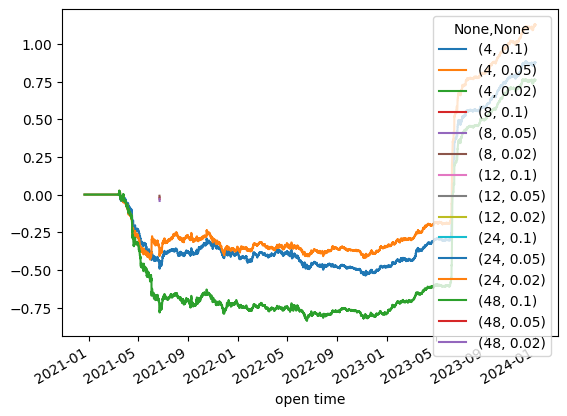

In [39]:
net_return_variations_2w_from_csv.cumsum().plot()

<Axes: xlabel='open time'>

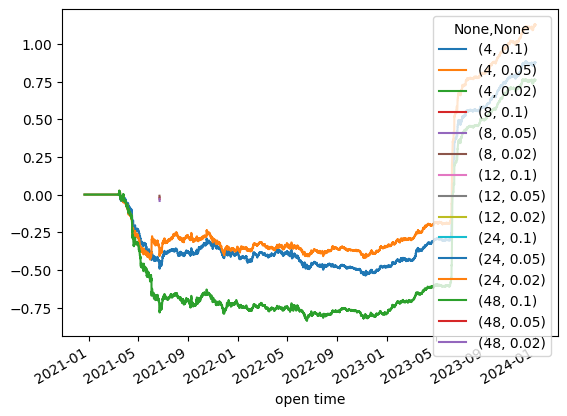

In [40]:
net_return_variations_4w_from_csv.cumsum().plot()

<Axes: xlabel='open time'>

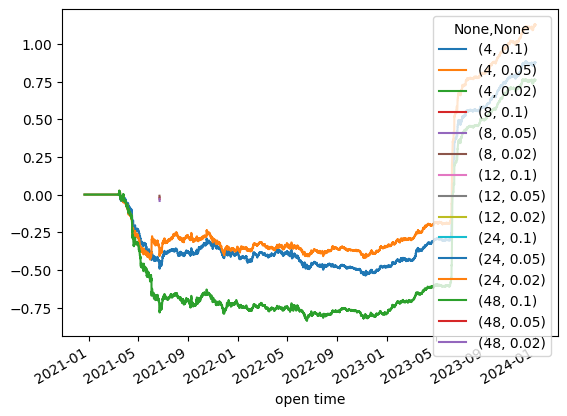

In [41]:
net_return_variations_6w_from_csv.cumsum().plot()

# Section For Experimentation

In [ ]:
x = get_returns_from_dynamic_cointegration(4, popular_train_px)

In [ ]:
gross_returns, net_returns = get_gross_returns_and_net_returns(x, popular_train_px)

In [ ]:
gross_returns, net_returns = get_returns_from_dynamic_cointegration(4, full_train_px)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

gross_returns.cumsum().plot(ax=axes[0], title='Cumulative Gross Returns', color='blue')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True)

# Plot the second Series on the second subplot (axes[1])
net_returns.cumsum().plot(ax=axes[1], title='Cumulative Net Returns', color='red')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Cumulative Return')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
gross_returns_8h, net_returns_8h = get_returns_from_dynamic_cointegration(
    8, get_horizon_to_px(full_train_px)[8])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

gross_returns_8h.cumsum().plot(ax=axes[0], title='Cumulative Gross Returns', color='blue')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True)

# Plot the second Series on the second subplot (axes[1])
net_returns_8h.cumsum().plot(ax=axes[1], title='Cumulative Net Returns', color='red')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Cumulative Return')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
gross_returns_12h, net_returns_12h = get_returns_from_dynamic_cointegration(
    12, get_horizon_to_px(full_train_px)[12])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

gross_returns_12h.cumsum().plot(ax=axes[0], title='12-Hour Cumulative Gross Returns', color='blue')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True)

# Plot the second Series on the second subplot (axes[1])
net_returns_12h.cumsum().plot(ax=axes[1], title='12-Hour Cumulative Net Returns', color='red')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Cumulative Return')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
gross_returns_24h, net_returns_24h = get_returns_from_dynamic_cointegration(
    24, get_horizon_to_px(full_train_px)[24])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

gross_returns_24h.cumsum().plot(ax=axes[0], title='24-Hour Cumulative Gross Returns', color='blue')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True)

# Plot the second Series on the second subplot (axes[1])
net_returns_24h.cumsum().plot(ax=axes[1], title='24-Hour Cumulative Net Returns', color='red')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Cumulative Return')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
results_map = {
    "gross returns, 4h": gross_returns,
    "net returns, 4h": net_returns,
    "gross returns, 8h": gross_returns_8h,
    "net returns, 8h": net_returns_8h,
    "gross returns, 12h": gross_returns_12h,
    "net returns, 12h": net_returns_12h,
    "gross returns, 24h": gross_returns_24h,
    "net returns, 24h": net_returns_24h,
}

should_write_map = False

if should_write_map:
    pd.DataFrame(results_map).to_csv('./cointegration_results.csv', index=True)

In [ ]:
pd.Series(get_strategy_stats(net_returns, 4, get_horizon_to_px(full_train_px)[4])).to_frame()

- Time horizon of data: 4h, 8h, 12h, 24h, 48h
- Method of identification of cointegrated pairs
    - Fixed set of cointegrated pairs calculated from a training period
    - Dynamically determined cointegrated pairs calculated each period or every several periods
- Method of hedge-ratio calculation:
    - Pairs with a fixed hedge ratio calculated from a training period
    - Pairs with a dynamic hedge ratio calculated from a look-back period
- Significance level for being considered cointegrated:
    - 0.10
    - 0.05
    - 0.02
- Entry and exit levels
- Lookback window length to calculate z-score (presumably shorter than window to calculate dynamic hedge ratio)

Separate idea:
- Use price for cointegration or use returns for cointegration

In [ ]:
train_px_4h = get_horizon_to_px(popular_train_px)[4]

time_to_cointegrated_pairs = get_cointegrated_pairs_with_window(
    train_px_4h,
    num_look_back_periods = 6 * 7 * 8, # 8 weeks
    num_periods_between_recalculation = 6 * 7 * 2, # 2 weeks
    significance_level = 0.05)

time_to_cointegrated_pairs

In [ ]:
def get_updated_cointegration_index(
        cointegration_index,
        cointegration_recalculation_times,
        index,
        train_px_index_list
    ):
    if (cointegration_index is None and \
        train_px_index_list[index] >= cointegration_recalculation_times[0]):
        cointegration_index = 0
    elif cointegration_index is not None:
        while ((cointegration_index + 1) < len(cointegration_recalculation_times)) and \
            (train_px_index_list[index] >= cointegration_recalculation_times[cointegration_index + 1]):
            cointegration_index += 1
    
    return cointegration_index


def construct_signal(signal, cointegrated_pairs):
    pass


time_to_signal = dict()

cointegration_recalculation_times = sorted(list(time_to_cointegrated_pairs.keys()))
cointegration_index = None

train_px_index_list = train_px_4h.index
for index in range(len(train_px_4h)):
    cointegration_index = get_updated_cointegration_index(
        cointegration_index,
        cointegration_recalculation_times,
        index,
        train_px_index_list
    )
    
    if cointegration_index is None:
        time_to_signal[train_px_index_list[index]] = pd.Series(np.nan, index=train_px_4h.columns)
        continue
    
    _, cointegrated_pairs = time_to_cointegrated_pairs[cointegration_recalculation_times[cointegration_index]]
    
    signal = pd.Series(0.0, index = train_px_4h.columns)
    
    time_to_signal[train_px_index_list[index]] = construct_signal(signal, cointegrated_pairs)

In [ ]:


# def get_gross_and_net_returns_for_all_dynamic_cointegration_combinations(px):
#     horizon_to_px = get_horizon_to_px(px, datetime(2020, 12, 20), datetime(2023, 12, 31))
    
#     for num_hours in (4, 8, 12, 24, 48):
#         train_px_horizon = horizon_to_px[num_hours]
    
#         significance_level = 0.05
#         num_periods_between_recalculation = 24 / num_hours * 30
#         num_look_back_periods = 2 * num_periods_between_recalculation
        
#         time_to_cointegrated_pairs = get_cointegrated_pairs_with_window(
#             train_px_horizon, num_look_back_periods, num_periods_between_recalculation, significance_level)
        
        

    
# def get_gross_and_net_returns_for_fixed_cointegration_combinations(px):
#     pass

In [ ]:
horizon_to_px = get_horizon_to_px(popular_train_px, datetime(2020, 12, 20), datetime(2023, 12, 31))

num_hours = 4

# for num_hours in (4, 8, 12, 24, 48):
#     train_px_horizon = horizon_to_px[num_hours]

#     significance_level = 0.05
#     num_periods_between_recalculation = 24 / num_hours * 30
#     num_look_back_periods = 2 * num_periods_between_recalculation

#     time_to_cointegrated_pairs = get_cointegrated_pairs_with_window(
#         train_px_horizon, num_look_back_periods, num_periods_between_recalculation, significance_level)

train_px_horizon = horizon_to_px[num_hours]

significance_level = 0.05
num_periods_between_recalculation = int(24 / num_hours * 30)
num_look_back_periods = 2 * num_periods_between_recalculation

time_to_cointegrated_pairs = get_cointegrated_pairs_with_window(
    train_px_horizon, num_look_back_periods, num_periods_between_recalculation, significance_level)

In [ ]:
cointegration_identification_times = sorted(list(time_to_cointegrated_pairs.keys()))
cointegration_index = None
signal_map = dict()
date_index_arr = train_px_horizon.index


def get_updated_cointegration_index(cointegration_idx, time_idx, coint_id_times):
    if cointegration_idx is None:
        

for index in range(len(train_px_horizon)):
    time_index = date_index_arr[index]
    cointegration_index = get_updated_cointegration_index(cointegration_index, time_index, cointegration_identification_times)
    signal_map[time_index] = get_signal_at_index(index, time_index, train_px_horizon, cointegrated_pairs, hedge_map)

# Backtesting the strategy for one pair

In [ ]:
import statsmodels.api as sm

# --- Select a cointegrated pair for backtesting (e.g., BTC and ETH) ---
asset_x = 'LTCUSDT'
asset_y = 'ADAUSDT'

# Check if the selected pair is actually cointegrated
if (asset_x, asset_y, pvalue_matrix.loc[asset_x, asset_y]) in cointegrated_pairs or \
   (asset_y, asset_x, pvalue_matrix.loc[asset_y, asset_x]) in cointegrated_pairs:
    print(f"\nBacktesting the strategy for the pair: {asset_x} and {asset_y}")
else:
    print(f"\nWarning: The pair {asset_x} and {asset_y} is not found to be cointegrated at the 5% significance level.")
    print("Please choose a valid cointegrated pair from the previous step.")

# --- Calculate the hedge ratio and spread ---
# Perform a linear regression to find the hedge ratio
model = sm.OLS(px_popular[asset_y], sm.add_constant(px_popular[asset_x])).fit()
hedge_ratio = model.params[asset_x]
spread = px_popular[asset_y] - hedge_ratio * px_popular[asset_x]

# --- Backtesting logic ---
# Define trading parameters
window = 60 # Lookback window for mean and std dev
num_std_dev_entry = 2 # Number of standard deviations for entry
num_std_dev_exit = 0.5 # Number of standard deviations for exit

# Calculate rolling mean and standard deviation of the spread
rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()

# Calculate Bollinger Bands
upper_band = rolling_mean + num_std_dev_entry * rolling_std
lower_band = rolling_mean - num_std_dev_entry * rolling_std

# Create DataFrame for backtest
backtest_df = pd.DataFrame(index=spread.index)
backtest_df['spread'] = spread
backtest_df['rolling_mean'] = rolling_mean
backtest_df['rolling_std'] = rolling_std
backtest_df['upper_band'] = upper_band
backtest_df['lower_band'] = lower_band

# --- Generate trading signals ---
# Signal: 1 for long spread, -1 for short spread, 0 for no position
backtest_df['signal'] = 0.0
backtest_df.loc[backtest_df['spread'] > backtest_df['upper_band'], 'signal'] = -1.0
backtest_df.loc[backtest_df['spread'] < backtest_df['lower_band'], 'signal'] = 1.0

# Exit signal: close position when spread reverts to near the mean
backtest_df.loc[abs(backtest_df['spread']) < num_std_dev_exit * backtest_df['rolling_std'], 'signal'] = 0.0

# Forward-fill signals to hold positions
backtest_df['signal'] = backtest_df['signal'].replace(to_replace=0, method='ffill')

# --- Plot the spread and trading signals ---
plt.figure(figsize=(15, 8))
plt.plot(backtest_df.index, backtest_df['spread'], label='Spread')
plt.plot(backtest_df.index, backtest_df['rolling_mean'], label='Rolling Mean', linestyle='--')
plt.plot(backtest_df.index, backtest_df['upper_band'], label=f'{num_std_dev_entry} Std Dev', color='red')
plt.plot(backtest_df.index, backtest_df['lower_band'], label=f'-{num_std_dev_entry} Std Dev', color='red')
plt.title(f'Spread for {asset_y} and {asset_x}')

# Highlight entry and exit points
long_entries = backtest_df[backtest_df['signal'] == 1].index
short_entries = backtest_df[backtest_df['signal'] == -1].index
exits = backtest_df[backtest_df['signal'] == 0].index

plt.scatter(long_entries, backtest_df.loc[long_entries, 'spread'], marker='^', color='green', label='Long Entry')
plt.scatter(short_entries, backtest_df.loc[short_entries, 'spread'], marker='v', color='red', label='Short Entry')
plt.scatter(exits, backtest_df.loc[exits, 'spread'], marker='o', color='black', label='Exit')

plt.legend()
plt.show()

In [ ]:
backtest_df.iloc[110:140]

# Performance evaluation

In [ ]:
# --- Calculate daily returns of the assets ---
returns_x = px_popular[asset_x].pct_change()
returns_y = px_popular[asset_y].pct_change()

# --- Calculate strategy returns ---
# When 'signal' is 1 (long spread): long Y, short X
# When 'signal' is -1 (short spread): short Y, long X
strategy_returns = backtest_df['signal'].shift(1) * (returns_y - hedge_ratio * returns_x)

# --- Calculate cumulative returns ---
strategy_returns.dropna(inplace=True)
cumulative_returns = (1 + strategy_returns).cumprod()

# --- Plot cumulative returns ---
plt.figure(figsize=(15, 8))
plt.plot(cumulative_returns, label='Strategy Cumulative Returns')
plt.title('Statistical Arbitrage Strategy Performance')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

# --- Calculate performance metrics ---
total_return = (cumulative_returns.iloc[-1] - 1) * 100
annualized_return = (1 + strategy_returns.mean())**365 - 1
annualized_volatility = strategy_returns.std() * np.sqrt(365)
sharpe_ratio = annualized_return / annualized_volatility

print("\nStrategy Performance Metrics:")
print(f"Total Cumulative Return: {total_return:.2f}%")
print(f"Annualized Return: {annualized_return:.2f}")
print(f"Annualized Volatility: {annualized_volatility:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")